# Kaggle - Natural Language Processing with Disaster Tweets
### Predict which Tweets are about real disasters and which ones are not
https://www.kaggle.com/competitions/nlp-getting-started/overview

In [100]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb 
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

In [101]:
# load data
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [102]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [103]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [104]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [105]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


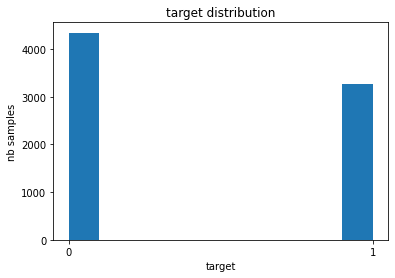

In [106]:
labels = df_train["target"]
plt.hist(labels)
plt.xlabel('target')
plt.ylabel('nb samples')
plt.title('target distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Loading the Pre-trained BERT model

In [107]:
model_class, tokenizer_class, pretrained_weights = (ppb.TFDistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [108]:
model.summary()

Model: "tf_distil_bert_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
Total params: 66,362,880
Trainable params: 66,362,880
Non-trainable params: 0
_________________________________________________________________


### Tokenization

In [109]:
def tokenize(sentences):
    tokenized = [tokenizer(sentence, add_special_tokens=True)['input_ids'] for sentence in sentences]
    return tokenized

In [110]:
tokenized = tokenize(df_train["text"])

In [111]:
print("sentence: ", df_train["text"][0] )
print("tokenized: ", tokenized[0])
print("decoded: ", tokenizer.decode(tokenized[0]))

sentence:  Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
tokenized:  [101, 2256, 15616, 2024, 1996, 3114, 1997, 2023, 1001, 8372, 2089, 16455, 9641, 2149, 2035, 102]
decoded:  [CLS] our deeds are the reason of this # earthquake may allah forgive us all [SEP]


### Padding

In [112]:
# get the maxh length
max_len = max(df_train["length"].max(), df_test["length"].max())
print("Max sentence length is ", max_len)

Max sentence length is  157


In [113]:
def pad_tokens(tokens, max_len):
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokens])
    return padded

In [114]:
padded = pad_tokens(tokenized, max_len)
print(padded[0])

[  101  2256 15616  2024  1996  3114  1997  2023  1001  8372  2089 16455
  9641  2149  2035   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]


In [115]:
print("shape of padded: ", padded.shape)

shape of padded:  (7613, 157)


### Masking

In [116]:
def get_attention_mask(tokens):
    attention_mask = np.where(tokens != 0, 1, 0)    
    return attention_mask

In [117]:
attention_mask = get_attention_mask(padded)
print(attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [118]:
print("shape of attention mask: ", attention_mask.shape)

shape of attention mask:  (7613, 157)


### Create input tensor

In [119]:
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)

### Extract feature vectors
The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [120]:
def extract_features(input_ids, attention_mask):
    batch_size = 500
    m = input_ids.shape[0]
    n = int(m / batch_size)

    hidden_units =  model.config.to_dict()['dim']
    features = np.zeros((m, hidden_units))

    print('Extract features using batches for memory issue:')

    for i in range(n):
        j, k = i*batch_size, i*batch_size+batch_size
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)

        # Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
        # The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of 
        # every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

        ## if you use BERT instead of distilBERT model, use this
        #features[j:k] = last_hidden_states[1].numpy() 

    if(n*batch_size != m):
        i = i + 1
        j, k = i*batch_size, i*batch_size+(m-n*batch_size)
        print(f'Batch {i+1} [{j}:{k}]')
        batch_input = input_ids[j:k]
        batch_attention_mask = attention_mask[j:k]
        last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)
        features[j:k] = last_hidden_states[0][:,0,:].numpy()

    return features

In [121]:
def get_features(input_ids, attention_mask, filename):
    if os.path.exists(filename):
        F = np.load(filename)
    else:
        F = extract_features(input_ids, attention_mask)
        np.save(filename, F)
    return F

In [122]:
features = get_features(input_ids, attention_mask, "data/E_train.npy")
print("shape of feature vectors: ", features.shape)

shape of feature vectors:  (7613, 768)


### Extract Labels

In [123]:
lables = df_train["target"].to_numpy()
print("shape of feature labels: ", labels.shape)

shape of feature labels:  (7613,)


### Train/Validation split

In [124]:
# 80% train, 20% validation
split_size = int(features.shape[0] * .8)    
X_train = features[:split_size,:]
Y_train = lables[:split_size]
X_val = features[split_size:,:]
Y_val = lables[split_size:]

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of validation data: ", X_val.shape, Y_val.shape)

shapes of training data:  (6090, 768) (6090,)
shapes of validation data:  (1523, 768) (1523,)


### Create the Logistic Regression Model

In [125]:
def create_model(input_shape, classes):
    inputs = keras.Input(shape=input_shape, name='input')
    #h1 = keras.layers.Dense(512, activation='sigmoid', name='h1')(inputs)    
    #d1 = keras.layers.Dropout(0.2, name='d1')(h1)
    #h2 = keras.layers.Dense(568, activation='sigmoid', name='h2')(h1)
    #d2 = keras.layers.Dropout(0.3, name='d2')(h2)
    #h3 = keras.layers.Dense(128, activation='sigmoid', name='h3')(d2)
    #d4 = keras.layers.Dropout(0.1, name='d4')(inputs)
    outputs = keras.layers.Dense(classes, activation='sigmoid', name='output')(inputs)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adamax()

    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['binary_accuracy']
    )

    return model

In [126]:
lr_model = create_model(X_train.shape[1], 1)
lr_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


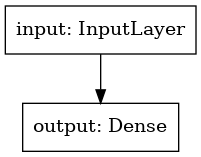

In [127]:
keras.utils.plot_model(lr_model)

### Train the model

In [128]:
history = lr_model.fit(
    X_train,
    Y_train,
    epochs=200,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/200
39/39 [==============================] - 1s 12ms/step - loss: 0.6214 - binary_accuracy: 0.6892 - val_loss: 0.5838 - val_binary_accuracy: 0.7742
Epoch 2/200
39/39 [==============================] - 0s 3ms/step - loss: 0.5653 - binary_accuracy: 0.7570 - val_loss: 0.5458 - val_binary_accuracy: 0.7865
Epoch 3/200
39/39 [==============================] - 0s 2ms/step - loss: 0.5366 - binary_accuracy: 0.7638 - val_loss: 0.5234 - val_binary_accuracy: 0.7947
Epoch 4/200
39/39 [==============================] - 0s 2ms/step - loss: 0.5174 - binary_accuracy: 0.7691 - val_loss: 0.5076 - val_binary_accuracy: 0.7947
Epoch 5/200
39/39 [==============================] - 0s 3ms/step - loss: 0.5053 - binary_accuracy: 0.7711 - val_loss: 0.4967 - val_binary_accuracy: 0.7964
Epoch 6/200
39/39 [==============================] - 0s 3ms/step - loss: 0.4968 - binary_accuracy: 0.7728 - val_loss: 0.4883 - val_binary_accuracy: 0.8046
Epoch 7/200
39/39 [==============================] - 0s 2ms/step - lo

In [129]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
195,0.405181,0.822250,0.407135,0.827586,195
196,0.404937,0.823276,0.407452,0.831691,196
197,0.404840,0.822865,0.407193,0.828407,197
198,0.404903,0.823071,0.408509,0.830870,198
199,0.404524,0.822865,0.406936,0.826765,199


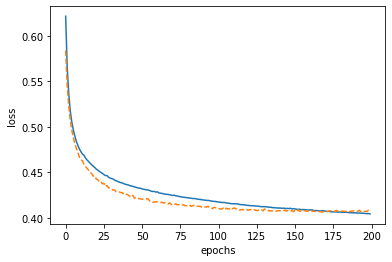

In [130]:
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')

### Model Evaluation

In [131]:
lr_model.evaluate(X_val, Y_val)

48/48 [==============================] - 0s 921us/step - loss: 0.3930 - binary_accuracy: 0.8313


[0.39298349618911743, 0.8312541246414185]

In [132]:
pred = lr_model.predict(X_val)
pred = pred > .5
pred =(pred[:,0]).astype(int)


In [133]:
tp = np.logical_and(pred == 1, Y_val == 1).sum()  # true positive
tn = np.logical_and(pred == 0, Y_val == 0).sum()  # true negative
fp = np.logical_and(pred == 1, Y_val == 0).sum()  # false positive
fn = np.logical_and(pred == 0, Y_val == 1).sum()  # false negative

precision = tp/(tp+fp)
recall = tp/(tp+fn)

f1_score = 2*(precision*recall)/(precision+recall)

print("True Positive: ", tp)
print("True Negative: ", tn)
print("False Positive: ", fp)
print("false Negative: ", fn)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1_score)


True Positive:  535
True Negative:  731
False Positive:  83
false Negative:  174
Precision:  0.8656957928802589
Recall:  0.7545839210155149
F1 Score:  0.8063300678221553


In [134]:
def displayConfusionMatrix(y_test, pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        pred,
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

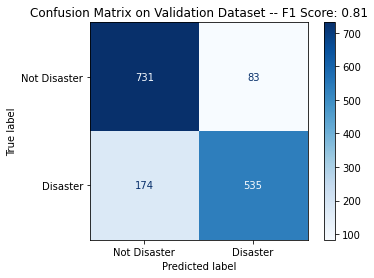

In [135]:
displayConfusionMatrix(Y_val, pred, "Validation")

### Inference

In [136]:
test_tokenized = tokenize(df_test["text"])
test_padded = pad_tokens(test_tokenized, max_len)
print("shape of test_padded: ", test_padded.shape)

shape of test_padded:  (3263, 157)


In [137]:
test_attention_mask = get_attention_mask(test_padded)
print("shape of test attention mask: ", test_attention_mask.shape)

shape of test attention mask:  (3263, 157)


In [138]:
test_input_ids = tf.convert_to_tensor(test_padded, dtype=tf.int32)
test_attention_mask = tf.convert_to_tensor(test_attention_mask, dtype=tf.int32)

In [139]:
test_features = get_features(test_input_ids, test_attention_mask, "data/E_test.npy")
print("shape of test_feature vectors: ", test_features.shape)

shape of test_feature vectors:  (3263, 768)


In [140]:
X_test = test_features

In [141]:
pred_test = lr_model.predict(X_test)
pred_test = pred_test > .5
pred_test =(pred_test[:,0]).astype(int)

In [142]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [143]:
sample_submission["target"] = pred_test
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [144]:
sample_submission.describe()

,id,target
count,3263.000000,3263.000000
mean,5427.152927,0.362243
std,3146.427221,0.480722
min,0.000000,0.000000
25%,2683.000000,0.000000
50%,5500.000000,0.000000
75%,8176.000000,1.000000
max,10875.000000,1.000000


In [145]:
sample_submission.to_csv("data/submission1.csv", index=False)